Технічний блокнот. Тут було проведено обробку даних та перевірку різних припущень що до кореляції.

In [34]:
import pandas as pd
import numpy as np

import copy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import math

In [35]:
def createdf(filename): #створення фрейму
    df = pd.read_csv(filename)
    
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.isnull().any()
    return(df)

In [36]:
filename = "csv//int20h-ds-test-dataset.csv"

In [37]:
df = createdf(filename)

In [38]:
df["event_created_date"] = pd.to_datetime(df["event_created_date"])

In [39]:
print(str(df.shape[0]) +" rows x " + str(df.shape[1]) + " columns")
df.head()

23357 rows x 8 columns


,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [40]:
#drop users that have not added, renewed or canceled Subscription Premium - they haven't canceled it because they had no sub

def remove_excess_data(df):
    target_values = ['Subscription Premium Cancel', 'Subscription Premium', 'Subscription Premium Renew', "Order"]
    sign_up_value = "Sign Up Success"
    user_list = df["userid"].unique()
    for i in user_list:
        df_temp = df[df["userid"]==i]
        if target_values[0] in df_temp.values or target_values[1] in df_temp.values:
            continue
        elif target_values[2] in df_temp.values or  target_values[3] in df_temp.values:
            continue
        elif (sign_up_value not in df_temp.values):
            continue
        df = df.drop(df_temp.index)
    return df

In [41]:
df = remove_excess_data(df)

In [42]:
df = df.sort_values(["userid", "event_created_date"], ascending=[True, True]).reset_index(drop = True)

In [43]:
#Замінюємо невідомі значення пристроїв з яких виконувалися дії 
#користувачів для яких відомий пристрій за іншими діями на ці пристрої
def fill_in_NaNs(df):
    
    for i in range(len(df)):
        if df.loc[i, "event_platform"] == "outofband":
            df_temp = df[df["userid"] == df.iloc[i]["userid"]]
            for index, row in df_temp.iterrows():
                if row["event_platform"] != "outofband":
                    df.loc[i, "event_platform"] = row.at["event_platform"]
                    df.loc[i, "device_manufacture"] = row.at["device_manufacture"]
                    df.loc[i, "device_model"] = row.at["device_model"]
                    break
                    
    df_temp = df[df["user_state"].apply(lambda x: isinstance(x, float))]
    df = df.drop(df_temp.index).reset_index(drop = True)
    
    return df


In [44]:
df = fill_in_NaNs(df).reset_index(drop = True)
df_canceled = df[df["event_name"] == 'Subscription Premium Cancel']
#print(str(df_canceled.shape[0]) +" rows x " + str(df_canceled.shape[1]) + " columns")
canceled_list = df_canceled["userid"].unique()
df_canceled.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
75,03e0c91e1163e8b80e74e586a3e666d6,MD,Subscription Premium Cancel,{},2022-02-24 19:45:02,ios,Apple,"iPhone12,1"
171,051a5f8bce75a601be987980a09d4187,VA,Subscription Premium Cancel,{},2022-04-06 10:12:37,ios,Apple,"iPhone14,2"
180,05630c0e889fe7371fc74d7ae01f491f,FL,Subscription Premium Cancel,{},2022-03-19 18:16:37,ios,Apple,"iPhone13,2"
195,060153cf7a5844d9aed735d408b35f97,TX,Subscription Premium Cancel,{},2022-02-11 15:06:11,ios,Apple,"iPhone14,2"
215,078ae59f1ae79df514e846e5e51eca8b,CA,Subscription Premium Cancel,{},2022-04-09 12:43:36,ios,Apple,"iPhone12,1"


In [45]:
def event_occured_per_user(row):
    if row['userid'] in event_list:
        return 1
    else:
        return 0

In [46]:
def event_occured(row):
    if row["event_name"] == event:
        return 1
    else:
        return 0

In [47]:
event = 'Subscription Premium Cancel'
df_temp = df[df["event_name"] == event]
event_list = df_temp["userid"].unique()
df[event] = df.apply(event_occured_per_user, axis=1)

In [48]:
df.to_csv("csv//sorted_filled_test.csv")

In [49]:
df = createdf("csv//sorted_filled_test.csv")

In [17]:
#виводимо з значення дати значення місяця, квартал, день тижня та час події в хвилинах
def event_created_date_transform(df):
    date = pd.DataFrame({"time" : []})
    date["time"] = pd.to_datetime(df["event_created_date"])
    date["month"] = date["time"].dt.month
    date["quarter"] = date["time"].dt.quarter
    date["day_week"] = date["time"].dt.dayofweek
    #date["time"] = (date["time"].dt.minute.to_numpy(dtype=np.int32) + date["time"].dt.hour.to_numpy(dtype=np.int32)*60)/(60*24) #minute of the day
    date["time"] = date["time"].dt.hour.to_numpy(dtype=np.int32) #hour of the day
    return date

In [18]:
date = event_created_date_transform(df)

In [19]:
date.to_csv("csv//extracted_date_data.csv")

In [20]:
df_canceled = df[df["event_name"] == 'Subscription Premium Cancel']
canceled_list = df_canceled["userid"].unique()

In [21]:
df_time = copy.deepcopy(df)

In [22]:
event = 'Subscription Premium Cancel'
df_time[event] = df_time.apply(event_occured, axis=1)

In [23]:
df_time = df_time.drop(['userid', 'event_name', 'event_attributes',
                        'event_created_date', "user_state", "event_platform","device_manufacture", "device_model"], axis=1)

In [24]:
df_time = pd.concat([df_time, date], axis=1)

In [25]:
df_time.to_csv("csv//event_and_date_data.csv")

In [ ]:
# Event per user

In [26]:
df_event_occured = copy.deepcopy(df)
events = df["event_name"].unique()

In [27]:
for e in events:
    event = e
    df_temp = df_event_occured[df_event_occured["event_name"] == event]
    event_list = df_temp["userid"].unique()
    df_event_occured[event] = df_event_occured.apply(event_occured_per_user, axis=1)

In [28]:
df_event_occured = df_event_occured.drop(['event_name', 'event_attributes', 'event_created_date',
                                          "user_state", "event_platform","device_manufacture", "device_model"], axis=1)

In [29]:
df_event_occured = df_event_occured.drop_duplicates(subset = ["userid"])

In [31]:
df_event_occured.to_csv("csv//event_occured_per_user.csv")

In [122]:
df2 = copy.deepcopy(df)

In [123]:
label_encoder = LabelEncoder()
df_static_data = copy.deepcopy(df2.drop(['event_name', 'event_attributes', 'event_created_date'], axis=1))

df_static_data = df_static_data.drop_duplicates(subset = ["userid"])

In [124]:

categories = ["user_state", "event_platform","device_manufacture", "device_model"]
for category in categories:
    df_static_data[category]=label_encoder.fit_transform(df_static_data[category])


In [125]:
#dataplot = sns.heatmap(df_static_data.corr(), cmap="RdYlBu", annot=True)
#plt.show()

In [126]:
df_static_data.to_csv("csv//static_data.csv")

In [127]:
df_feature_by_state = copy.deepcopy(df)
events = df["event_name"].unique()


In [128]:

def event_occured_per_state(row):
    if row['user_state'] in event_list:
        return 1
    else:
        return 0


In [129]:

for e in events:
    event = e
    if (event == 'Subscription Premium Cancel'):
        continue
    df_temp = df_feature_by_state[df_feature_by_state["event_name"] == event]
    event_list = df_temp["user_state"].unique()
    df_feature_by_state[event] = df_feature_by_state.apply(event_occured_per_state, axis=1)

In [130]:
df_feature_by_state = df_feature_by_state.drop(['event_attributes', 'event_created_date', 
                                                "event_platform","device_manufacture", "device_model"], axis=1)

In [131]:
#df_feature_by_state = df_feature_by_state.drop_duplicates(subset = ["user_state"])

In [132]:
#df_feature_by_state.groupby(["user_state", 'Subscription Premium Cancel'])["user_state"].count().unstack(fill_value=0).stack()

In [133]:
count = df_feature_by_state.groupby(["user_state", 'Subscription Premium Cancel'])["user_state"].count().unstack(fill_value=0).stack()

In [134]:
len(count)

72

In [135]:
cancel_percentage = [float(count[2*i + 1])/(count[2*i] + count[2*i + 1]) for i in range(int(len(count)/2))]

In [136]:
df_feature_per_state = copy.deepcopy(df_feature_by_state)

df_feature_per_state = df_feature_per_state.drop(['Subscription Premium Cancel', 'Subscription Premium', 'Subscription Premium Renew', 'Sign Up Success'], axis=1)
df_feature_per_state = df_feature_per_state.drop_duplicates(subset = ["user_state"])

df_feature_per_state = df_feature_per_state.drop(['userid', 'event_name'], axis = 1).sort_values(["user_state"]).reset_index(drop = True)
#df_feature_per_state

In [137]:
df_feature_per_state["cancel_percentage"] = cancel_percentage

In [163]:
df_feature_per_state.corr()["cancel_percentage"]

Add Payment Method Success             0.173526
Account History Transaction Details   -0.115623
Add Vehicle Success                   -0.422327
Order                                 -0.470743
Chat Conversation Opened               0.254613
Add Vehicle Break                     -0.045242
Chat Conversation Started              0.363799
Email Confirmation Success            -0.230750
Add Payment Method Failed             -0.238653
Account Setup Skip                    -0.106902
Calculator View                       -0.201246
Wallet Opened                          0.290012
Account Setup Profile Skip            -0.108586
Sign Out                               0.033762
Transaction Refund                     0.247031
Calculator Used                       -0.209809
Add Vehicle Failed                    -0.066353
Sign Up Error                          0.032386
Reset Password Set                    -0.173526
cancel_percentage                      1.000000
Name: cancel_percentage, dtype: float64

In [ ]:
#df for errors

In [168]:
def remove_excess_events(df, tv):
    target_values = tv
    event_list = df["event_name"].unique()
    for i in event_list:
        df_temp = df[df["event_name"]==i]
        if i in target_values:
            continue
        df = df.drop(df_temp.index)
    return df

In [169]:
tv = ['Add Vehicle Break', 'Add Vehicle Failed', 'Add Vehicle Success', 
                     "Add Payment Method Failed", "Add Payment Method Success"]
df_errors = copy.deepcopy(df)
df_errors = remove_excess_events(df_errors, tv)
count = df_errors.groupby(["userid", "event_name"])["event_name"].count().unstack(fill_value=0).stack()

In [170]:
target_values = ['Add Vehicle Break', 'Add Vehicle Failed', 'Add Vehicle Success', "Add Payment Method Failed", "Add Payment Method Success"]


In [171]:
targer_values_count = [[count[5*j + i] for j in range(int(len(count)/5))] for i in range(5)]

for i in range(int(len(count)/5)):
    if (count[5*i + 2] + count[5*i + 3] + count[5*i + 4]) == 0:
        count[5*i + 2] = 1
    if (count[5*i] + count[5*i + 1]) == 0:
        count[5*i] = 1
error_rate_vehicle = [float(count[5*i + 4])/(count[5*i + 2] + count[5*i + 3] + count[5*i + 4]) for i in range(int(len(count)/5))]
error_rate_payment = [float(count[5*i + 1])/(count[5*i] + count[5*i + 1]) for i in range(int(len(count)/5))]

In [172]:
#print(len(error_rate_vehicle))
#df_errors.drop_duplicates(subset = ["userid"])

In [173]:
df_errors = df_errors.drop_duplicates(subset = ["userid"])
df_errors = df_errors.drop(['event_name', 'event_attributes', 'event_created_date',
                                          "user_state", "event_platform","device_manufacture", "device_model"], axis=1)
df_errors["error_rate_vehicle"] = error_rate_vehicle
df_errors["error_rate_payment"] = error_rate_payment
for i in range(5):
    df_errors[target_values[i]] = targer_values_count[i]

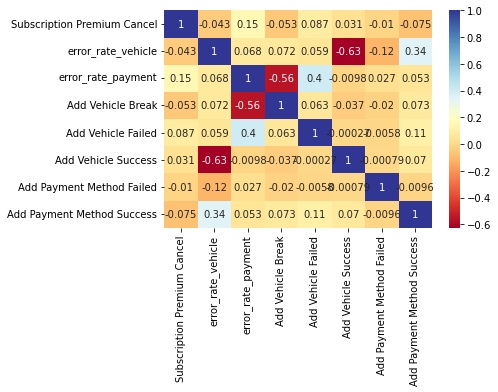

In [174]:
dataplot = sns.heatmap(df_errors.corr(), cmap="RdYlBu", annot=True)
plt.show()

In [175]:
df_errors.to_csv("csv//error_data.csv")

In [575]:
df_feature_per_state.to_csv("csv//feature_per_state.csv")

In [ ]:
df_feature_per_state2 = copy.deepcopy(df_feature_by_state)

In [508]:
df_feature_by_state.to_csv("csv//feature_by_state.csv")

In [ ]:
#Working with dates of events for Order and Subscription/Subscription Renew

In [59]:
last_activity_date = max(df['event_created_date'])
last_activity_date

'2022-04-16 20:50:39'

In [60]:
def last_event_activity(row):
    if row[event] == 1:
        df_t = (df2[(df2['userid']==row['userid'])&(df2['event_name'] == event)]["event_created_date"])
        if(len(df_t)>0):
            return max(df_t)
        else: return last_activity_date
    else:
        return last_activity_date

In [33]:
tv = ['Order', 'Subscription Premium Cancel']
df_orders = copy.deepcopy(df)
#df_orders = remove_excess_events(df_orders, tv)
df_orders = df_orders.drop(["user_state", "event_platform","device_manufacture", "device_model"], axis=1)

event = 'Order'
df_temp = df[df["event_name"] == event]
event_list = df_temp["userid"].unique()

df_orders[event] = df_orders.apply(event_occured_per_user, axis=1)
df2 = copy.deepcopy(df_orders)
df_orders = df_orders.drop_duplicates(subset = ["userid"])

In [34]:


def order_difference_d(row):
    if (row['Order']==0 and row['Subscription Premium Cancel']==1):
        return -1
    difference = ((np.datetime64(row["last date Subscription Premium Cancel"][:10]) - np.datetime64(row["last date Order"][:10])))
    return max(int(difference / np.timedelta64(1, 'D')), 0)

def order_difference_m(row):
    if (row['Order']==0 and row['Subscription Premium Cancel']==1):
        return -1
    difference = ((np.datetime64(row["last date Subscription Premium Cancel"][:10]) - np.datetime64(row["last date Order"][:10])))
    return max(int((difference / np.timedelta64(1, 'D'))/30), 0)

def order_difference_more_than_month(row):
    if (row['Order']==0 and row['Subscription Premium Cancel']==1):
        return 1
    difference = ((np.datetime64(row["last date Subscription Premium Cancel"][:10]) - np.datetime64(row["last date Order"][:10])))
    difference = int(int(difference / np.timedelta64(1, 'D')/30))
    return min(difference, 1)


def order_difference_more_than_10_days(row):
    if (row['Order']==0 and row['Subscription Premium Cancel']==1):
        return 1
    difference = ((np.datetime64(row["last date Subscription Premium Cancel"][:10]) - np.datetime64(row["last date Order"][:10])))
    difference = int(difference / np.timedelta64(1, 'D'))
    if (difference>10):
        return 1
    else: return 0

In [35]:
for ev in tv:
    event = ev
    df_orders["last date "+event] = df_orders.apply(last_event_activity, axis=1)

df_orders = df_orders[df_orders['Order'] == 1] #!!!!

df_orders["difference of days"] = df_orders.apply(order_difference_d, axis=1)
df_orders["difference of months"] = df_orders.apply(order_difference_m, axis=1)
df_orders["month had passed"] = df_orders.apply(order_difference_more_than_month, axis=1)
df_orders["10 days had passed"] = df_orders.apply(order_difference_more_than_10_days, axis=1)

In [36]:
df_orders = df_orders.drop(['userid', 'last date Order', 'last date Subscription Premium Cancel', 'event_name', 'event_attributes','event_created_date', 'Order'], axis = 1)

,Subscription Premium Cancel,difference of days,difference of months,month had passed,10 days had passed
6,0,42,1,1,1
76,0,2,0,0,0
128,0,57,1,1,1
141,0,0,0,0,0
172,1,0,0,0,0
...,...,...,...,...,...
16692,0,36,1,1,1
16770,1,0,0,0,0
16783,0,54,1,1,1
16847,0,17,0,0,1


In [139]:
#dataplot = sns.heatmap(df_orders.corr(), cmap="RdYlBu", annot=True)
#plt.show()

In [38]:
df_orders.to_csv("csv//date_between_order_and_cancel.csv")

In [39]:
#last_activity_date = df_orders.groupby('userid').tail(1).drop(["event_name", "event_attributes"], axis = 1)

In [40]:

#df[df["event_name"] == 'Transaction Refund']["event_attributes"].unique()

In [74]:
df = createdf("csv//sorted_filled_test.csv")

In [76]:
df_return_annual_monthly = copy.deepcopy(df)

In [50]:
import json

df['event_attributes'] = df['event_attributes'].apply(json.loads)

event_attributes = df['event_attributes'].to_list()
event_attributes_df = pd.DataFrame(event_attributes)

enriched_df = df.join(event_attributes_df)
enriched_df = enriched_df.drop(columns='event_attributes')

enriched_df.head()

,userid,user_state,event_name,event_created_date,event_platform,device_manufacture,device_model,Subscription Premium Cancel,Payment Method,Tokenized Pay,...,Error Code,Error Message,Screen,Transaction type,Id,Amount,Description,Google Map Installed,Selected Route Type,Transaction Type
0,0006869712ec9841dc36234bce245203,MD,Add Payment Method Success,2022-01-19 18:47:45,android,samsung,SM-A716U,0,Debit,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0006869712ec9841dc36234bce245203,MD,Subscription Premium,2022-01-19 18:48:01,android,samsung,SM-A716U,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,2022-01-19 18:48:08,android,samsung,SM-A716U,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,2022-01-19 18:48:44,android,samsung,SM-A716U,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0006869712ec9841dc36234bce245203,MD,Add Vehicle Success,2022-01-19 18:50:34,android,samsung,SM-A716U,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
enriched_df.columns

Index(['userid', 'user_state', 'event_name', 'event_created_date',
       'event_platform', 'device_manufacture', 'device_model',
       'Subscription Premium Cancel', 'Payment Method', 'Tokenized Pay',
       'Start Date', 'Renewal Date', 'Membership Type', 'Navigated From',
       'Status', 'Type', 'Make', 'Model', 'Color', 'Year', 'Temporary',
       'End Date', 'Rental state', 'Method', 'Premium Membership',
       'Rental State', 'Promo code', 'From', 'Required', 'Error Code',
       'Error Message', 'Screen', 'Transaction type', 'Id', 'Amount',
       'Description', 'Google Map Installed', 'Selected Route Type',
       'Transaction Type'],
      dtype='object')

In [79]:
enriched_df["Membership Type"].unique()

array([nan, 'Monthly', 'Yearly'], dtype=object)

In [80]:
event_list = [enriched_df[enriched_df["Membership Type"]==i]['userid'].unique() for i in ['Monthly', 'Yearly']]

In [81]:
def event_occured_per_user(row):
    if row['userid'] in event_list:
        return 1
    else:
        return 0
#for i in range(2):
    

In [82]:
tv = ['Subscription Premium', 'Subscription Premium Renew']

In [83]:
df_return_annual_monthly = df_return_annual_monthly.drop(["user_state", "event_platform","device_manufacture", "device_model"], axis=1)

event = tv[1]
df_temp = df[df["event_name"] == event]
event_list = df_temp["userid"].unique()


df_return_annual_monthly[event] = df_return_annual_monthly.apply(event_occured_per_user, axis=1)

event = tv[0]
df_temp = df[df["event_name"] == event]
event_list = df_temp["userid"].unique()



df_return_annual_monthly[event] = df_return_annual_monthly.apply(event_occured_per_user, axis=1)

In [84]:

df2 = copy.deepcopy(df_return_annual_monthly)
df_return_annual_monthly = df_return_annual_monthly.drop_duplicates(subset = ["userid"])

In [68]:
def event_occured_per_user(row):
    if row['userid'] in event_list:
        return 1
    else:
        return 0
    


def event_difference_d(row):
    if (row[event]==0 and row['Subscription Premium Cancel']==1):
        return -1
    difference = ((np.datetime64(row["last date Subscription Premium Cancel"][:10]) - np.datetime64(row["last date "+event][:10])))
    return max(int(difference / np.timedelta64(1, 'D')), 0)

def event_difference_m(row):
    if (row[event]==0 and row['Subscription Premium Cancel']==1):
        return -1
    difference = ((np.datetime64(row["last date Subscription Premium Cancel"][:10]) - np.datetime64(row["last date "+event][:10])))
    return max(int((difference / np.timedelta64(1, 'D'))/30), 0)

def event_difference_less_than_month(row):
    if (row[event]==0 and row['Subscription Premium Cancel']==1):
        return 1
    difference = ((np.datetime64(row["last date Subscription Premium Cancel"][:10]) - np.datetime64(row["last date "+event][:10])))
    difference = int(int(difference / np.timedelta64(1, 'D')/30))
    return min(difference, 1)


def event_difference_less_than_2_days(row):
    if (row[event]==0 and row['Subscription Premium Cancel']==1):
        return 1
    difference = ((np.datetime64(row["last date Subscription Premium Cancel"][:10]) - np.datetime64(row["last date "+event][:10])))
    difference = int(difference / np.timedelta64(1, 'D'))
    if (difference<2):
        return 1
    else: return 0

In [86]:

event = "Subscription Premium Cancel"
df_return_annual_monthly["last date "+event] = df_return_annual_monthly.apply(last_event_activity, axis=1)

for ev in tv: 
    event = ev
    df_return_annual_monthly["last date "+event] = df_return_annual_monthly.apply(last_event_activity, axis=1)
        
    df_return_annual_monthly["delta days " + event] = df_return_annual_monthly.apply(event_difference_d, axis=1)
    df_return_annual_monthly["delta months" + event] = df_return_annual_monthly.apply(event_difference_m, axis=1)
    df_return_annual_monthly["month had passed "+ event] = df_return_annual_monthly.apply(event_difference_less_than_month, axis=1)
    df_return_annual_monthly["2 days had not passed "+ event] = df_return_annual_monthly.apply(event_difference_less_than_2_days, axis=1)

In [87]:
#fig, ax = plt.subplots(figsize=(15,15))
#dataplot = sns.heatmap(df_return_annual_monthly.corr(), cmap="RdYlBu", annot=True)
#plt.show()

In [88]:
df_return_annual_monthly.to_csv("csv//date_between_renew_and_cancel.csv")

In [ ]:
# working with subscription and subscription renew

In [89]:
renew_check = copy.deepcopy(df[df["event_name"] == 'Subscription Premium Renew'])
subscription_check = copy.deepcopy(df[df["event_name"] == 'Subscription Premium'])

In [90]:
subscription_check["Sign Up Success"] = [1]*len(subscription_check)
subscription_check['Subscription Premium'] = [1]*len(subscription_check)
renew_check['Subscription Premium Renew'] = [1]*len(renew_check)

In [91]:
def membership_type(row):
    df2 = enriched_df
    df_t = (df2[(df2['userid']==row['userid'])&(df2['event_name'] == event)])
    if(len(df_t)>0):
        df_t = df_t[df_t["event_created_date"] == max(df_t["event_created_date"])]
        membership = df_t["Membership Type"].values[0]
        #print(membership)
        return (membership)
    else: return -1

In [93]:
renew_check = renew_check.drop(["user_state", "event_platform","device_manufacture", "device_model"], axis=1)
subscription_check = subscription_check.drop(["user_state", "event_platform","device_manufacture", "device_model"], axis=1)

In [94]:
event = "Subscription Premium Cancel"
renew_check["last date "+event] = renew_check.apply(last_event_activity, axis=1)
subscription_check["last date "+event] = subscription_check.apply(last_event_activity, axis=1)



event =  'Subscription Premium Renew'
renew_check["last date "+ event] = renew_check.apply(last_event_activity, axis=1)
#renew_check["Membership"] = renew_check.apply(membership_type, axis=1)
renew_check["Membership YM"]  = renew_check.apply(membership_type, axis=1)
renew_check["2 days had not passed" + event]  = renew_check.apply(event_difference_less_than_2_days, axis=1)

event =  'Subscription Premium'
subscription_check["Membership YM"]  = subscription_check.apply(membership_type, axis=1)

In [140]:

tv =  ['Subscription Premium', "Sign Up Success"]
for ev in tv:
    event = ev
    subscription_check["last date "+event] = subscription_check.apply(last_event_activity, axis=1)
    subscription_check["2 days had not passed"+ event] = subscription_check.apply(event_difference_less_than_2_days, axis=1)

In [95]:
#subscription_check = subscription_check.drop_duplicates(subset = ["userid"])
#renew_check = renew_check.drop_duplicates(subset = ["userid"])

In [141]:
label_encoder = LabelEncoder()
categories = ["Membership YM"]
for category in categories:
    print(subscription_check[category].unique())
    subscription_check[category]=label_encoder.fit_transform(subscription_check[category])
    renew_check[category]=label_encoder.fit_transform(renew_check[category])
    print(subscription_check[category].unique())

In [98]:
renew_check = renew_check.drop(['Subscription Premium Renew'], axis = 1)
subscription_check = subscription_check.drop(['Subscription Premium', "Sign Up Success"], axis = 1)

In [142]:

#dataplot = sns.heatmap(renew_check.corr(), cmap="RdYlBu", annot=True)
#lt.show()

In [143]:

#dataplot = sns.heatmap(subscription_check.corr(), cmap="RdYlBu", annot=True)
#plt.show()

In [102]:
subscription_check.to_csv("csv//subscription_check.csv")

In [103]:
renew_check.to_csv("csv//renew_check.csv")

In [97]:
df_ultimate = copy.deepcopy(df)

In [98]:
events = df["event_name"].unique()

In [99]:
for e in events:
    event = e
    df_temp = df_ultimate[df_ultimate["event_name"] == event]
    event_list = df_temp["userid"].unique()
    df_ultimate[event] = df_ultimate.apply(event_occured_per_user, axis=1)

In [100]:
label_encoder = LabelEncoder()

In [101]:
def membership_type(row):
    df2 = enriched_df
    df_t = (df2[(df2['userid']==row['userid'])&(df2['event_name'] == event)])
    if(len(df_t)>0):
        df_t = df_t[df_t["event_created_date"] == max(df_t["event_created_date"])]
        membership = df_t["Membership Type"].values[0]
        #print(membership)
        return (membership)
    else: return str(-1)

In [102]:

event = "Subscription Premium Cancel"
df_ultimate["last date "+event] = df_ultimate.apply(last_event_activity, axis=1)

event =  'Subscription Premium Renew'
df_ultimate["last date "+ event] = df_ultimate.apply(last_event_activity, axis=1)
df_ultimate["Membership Ren"]  = df_ultimate.apply(membership_type, axis=1)
df_ultimate["2 days had not passed" + event]  = df_ultimate.apply(event_difference_less_than_2_days, axis=1)

event =  'Subscription Premium'
df_ultimate["Membership Sub"]  = df_ultimate.apply(membership_type, axis=1)
df_ultimate["last date "+ event] = df_ultimate.apply(last_event_activity, axis=1)
df_ultimate["2 days had not passed" + event]  = df_ultimate.apply(event_difference_less_than_2_days, axis=1)

In [103]:

def event_difference_m(row):
    if (row[event]==0 and row['Subscription Premium Cancel']==1):
        return -1
    difference = ((np.datetime64(row["last date Subscription Premium Cancel"][:10]) - np.datetime64(row["last date "+event][:10])))
    return max(int((difference / np.timedelta64(1, 'D'))/30), 0)


In [104]:
tv = ['Order', 'Subscription Premium Cancel']

event = 'Order'
df_temp = df[df["event_name"] == event]
event_list = df_temp["userid"].unique()

#df_orders = df_orders.drop_duplicates(subset = ["userid"])

In [105]:
df_ultimate["last date "+ event] = df_ultimate.apply(last_event_activity, axis=1)


df_ultimate["last date "+event] = df_ultimate.apply(last_event_activity, axis=1)
df_ultimate["delta months" + event] = df_ultimate.apply(event_difference_m, axis=1)


In [106]:
categories = ["user_state", "event_platform","device_manufacture", "device_model", "Membership Sub", "Membership Ren"]
for category in categories:
    #print(df_static_data[category].unique())
    df_ultimate[category]=label_encoder.fit_transform(df_ultimate[category])
    #print(df_static_data[category].unique())

In [107]:
df_ultimate = df_ultimate.drop_duplicates(subset = ["userid"])


In [108]:
df_ultimate.to_csv("csv//df_all.csv")

In [110]:
df_ultimate.corr()["Subscription Premium Cancel"]

user_state                                        -0.059272
event_platform                                    -0.056787
device_manufacture                                -0.022253
device_model                                      -0.060299
Subscription Premium Cancel                        1.000000
Add Payment Method Success                         0.133199
Subscription Premium                               0.208969
Account History Transaction Details                0.177464
Add Vehicle Success                                0.045470
Subscription Premium Renew                        -0.138581
Sign Up Success                                    0.131429
Order                                             -0.098363
Chat Conversation Opened                           0.479818
Add Vehicle Break                                  0.035817
Chat Conversation Started                          0.641984
Email Confirmation Success                         0.004407
Add Payment Method Failed               

In [111]:
from sklearn.model_selection import train_test_split